# PROJECT INTRODUCTION
  **Problem Statement** --> "We aim to proactively detect fraudulent transactions in a financial dataset of 6.3M records and 10 features."<br>
  **Why Fraud Detection Matters** --> "Since fraud is rare and highly imbalanced, we focus on precision at top K% and model interpretability."

## Importing Required Libraries

In [92]:

import os, json, joblib, gc, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
RANDOM_STATE = 42  # you can use any fixed number for reproducibility

# small utility
def precision_at_k(y_true, y_scores, k_fraction):
    n = len(y_true)
    k = max(1, int(np.floor(k_fraction * n)))
    idx = np.argsort(y_scores)[-k:]
    return y_true.reset_index(drop=True).iloc[idx].sum() / k


## Quick Checks

In [93]:

DATA_PATH = "Fraud.csv"
print("File exists:", os.path.exists(DATA_PATH))
print("File size (GB):", os.path.getsize(DATA_PATH)/(1024**3))


File exists: True
File size (GB): 0.4596400847658515


## Loading Data


In [94]:
# Cell 3: load data (use dtype optimization if needed)
df = pd.read_csv(DATA_PATH)
print("Rows,cols:", df.shape)
display(df.head())


Rows,cols: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Missing values & basic check


In [95]:
print("Missing percent per column:")
print(df.isna().mean()*100)
print("\nDtypes:\n", df.dtypes)

# quick fraud rate
print("\nFraud rate: ", df['isFraud'].mean())


Missing percent per column:
step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

Dtypes:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Fraud rate:  0.001290820448180152


# DATA QUALITY CHECK 
  **Missing Values** --> No missing values were found across all columns. <br>
  **Fraud Rate** --> Only 0.12% of the transactions are fraudulent, showing a highly   imbalanced dataset.<br>
  This imbalance is typical in fraud detection problems nd highlights the need for robust evaluation metrics (like ROC-AUC, PR-AUC, Precision@K) instead of accuracy.  

## Outlier detection & Multi-collinearity check

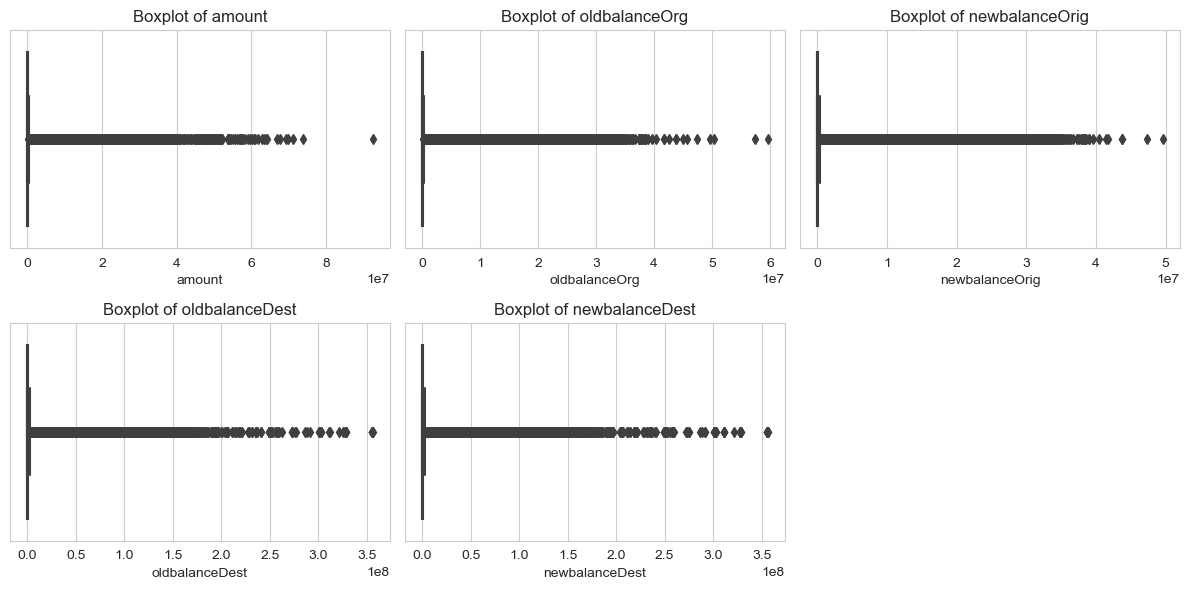

          feature         VIF
0          amount    3.861988
1   oldbalanceOrg  464.011728
2  newbalanceOrig  465.356124
3  oldbalanceDest   70.452251
4  newbalanceDest   82.167173


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Outlier check
numeric_cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

plt.figure(figsize=(12,6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Multi-collinearity check using VIF
X_num = df[numeric_cols].fillna(0)  # safe fill just in case
vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
print(vif_data)


# OUTLIER & MULTICOLLINEARITY ANALYSIS
  **Outliers** --> Boxplots revealed significant outliers in transaction amounts and balances.<br>
               --> We choose **not to remove them**, since fraudulent transactions themselves can appear as outliers.<br>
  **Multicollinearity** --> Variance Inflation Factor (VIF) analysis revealed very high collinearity among balance-related variables ('oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'), with VIF values > 100 in some cases.<br>
  High collinearity can destabilize linear models and inflate feature importance, so we addressed this in the next step.

## Drop highly collinear features (based on VIF analysis)



In [97]:
drop_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_reduced = df.drop(columns=drop_cols)

print("Using reduced dataset with:", df_reduced.shape[1], "features")


Using reduced dataset with: 7 features


# DATA CLEANING SUMMARY
  --> Removed **highly collinear features** ('oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest') to reduce redundancy and improve model interpretability.<br>
  --> Retained key features such as 'step', 'amount', 'type' (encoded), and fraud-related flags.<br>
  --> The cleaned dataset now has **reduced multicollinearity**and is ready for model training.
 
  

## Q1.DATA CLEANING ##
  --> No missing values found.
  --> Outliers detected in amount and balance fields using boxplots, but retained since fraud often appears as extreme values.
  --> Multicollinearity checked with VIF --> highly correlated balance features were dropped.

## Q3.FEATURE SELECTION ##
  --> Numeric features retained after removing multicollinear ones(VIF).<br>
  --> Transaction type encoded into dummy variables.<br>
  --> Feature importance validated with SHAP to ensure interpretability.

## Encode categorical variables


In [98]:
df_model = df_reduced.copy()
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)
df_model = df_model.drop(columns=['nameOrig', 'nameDest'])

print("Final dataset shape after encoding:", df_model.shape)
df_model.head()


Final dataset shape after encoding: (6362620, 8)


,step,amount,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,0,False,False,True,False
1,1,1864.28,0,0,False,False,True,False
2,1,181.00,1,0,False,False,False,True
3,1,181.00,1,0,True,False,False,False
4,1,11668.14,0,0,False,False,True,False


# ENCODING SUMMARY
  --> Converted transaction type ('type') into dummy variables ('CASH_OUT', 'TRANSFER', 'PAYMENT', 'DEBIT').<br>
  --> Removed identifier columns ('nameOrig', 'nameDest') since they don't provide predictive value.<br>
  --> Final dataset now has **8 cleaned and encoded features** ready for modelling.

# Splitting the Dataset

In [99]:
from sklearn.model_selection import StratifiedKFold, train_test_split
X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud']

# First split: Train+Calib vs Validation
X_temp, X_val, y_temp, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: Train vs Calibration
X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print("Train shape:", X_train.shape)
print("Calibration shape:", X_calib.shape)
print("Validation shape:", X_val.shape)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold+1}: Train={len(train_idx)}, Test={len(test_idx)}")


Train shape: (3817572, 7)
Calibration shape: (1272524, 7)
Validation shape: (1272524, 7)
Fold 1: Train=3054057, Test=763515
Fold 2: Train=3054057, Test=763515
Fold 3: Train=3054058, Test=763514
Fold 4: Train=3054058, Test=763514
Fold 5: Train=3054058, Test=763514


# DATA SPLITTING SUMMARY
  --> Dataset split into: **Training set** - 60%<br>
  --> **Calibration set** - 20%<br>
  --> **Validation set** - 20%<br>
  --> Used **Stratified K-Fold** to maintain class balance across splits.<br>
  --> Fraud remains highly imbalanced (~0.12%), so special care is needed in evaluation.<br>
  
  
      

## Baseline Logistic Regression

In [100]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
RANDOM_STATE = 42  
num_cols_baseline = X_train.select_dtypes(include=['number']).columns.tolist()

# Logistic Regression pipeline
baseline_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
)

# Fit
baseline_pipe.fit(X_train[num_cols_baseline], y_train)

# Predicting probabilities
y_val_proba_baseline = baseline_pipe.predict_proba(X_val[num_cols_baseline])[:, 1]

# Evaluating
print("Baseline ROC AUC:", roc_auc_score(y_val, y_val_proba_baseline))
print("Baseline PR AUC:", average_precision_score(y_val, y_val_proba_baseline))



Baseline ROC AUC: 0.7996358010226292
Baseline PR AUC: 0.02185006644305006


# BASELINE LOGISTICS REGRESSION
  --> Logistic Regression was trained on numeric features with class balancing.<br>
  --> Results : ROC AUC ~ 0.80 & PR AUC ~ 0.02 (very low due to imbalance).<br>
  --> While weak, this provides a **reference point** for improvement.

## LightGBM with StratifiedKFold

In [101]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

RANDOM_STATE = 42
lgb_params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "scale_pos_weight": (y_train.value_counts()[0] / y_train.value_counts()[1]),  # handle imbalance
    "n_estimators": 2000,
    "random_state": RANDOM_STATE,
    "n_jobs": -1
}

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_preds = np.zeros(len(X_train))
val_preds = np.zeros(len(X_val))
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}")
    X_tr, X_val_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric="auc",
        callbacks=[early_stopping(50), log_evaluation(100)]
    )
    
    oof_preds[valid_idx] = model.predict_proba(X_val_fold)[:,1]
    val_preds += model.predict_proba(X_val)[:,1] / skf.n_splits

# Evaluating CV performance
print("\nOOF ROC AUC:", roc_auc_score(y_train, oof_preds))
print("OOF PR AUC:", average_precision_score(y_train, oof_preds))
print("\nValidation ROC AUC:", roc_auc_score(y_val, val_preds))
print("Validation PR AUC:", average_precision_score(y_val, val_preds))



Fold 1
[LightGBM] [Info] Number of positive: 3942, number of negative: 3050115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 3054057, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651246
[LightGBM] [Info] Start training from score -6.651246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.951887	valid_0's binary_logloss: 3.31927

Fold 2
[LightGBM] [Info] Number of positive: 3942, number of negative: 3050115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518


# LIGHTGBM MODEL 
  --> Used LightGBM with 5-fold Stratified CV and early stopping.<br>
  --> Results : ROC AUC ~ 0.95(out-of-fold) & PR AUC ~ 0.10(much higher than baseline).<br>
  --> Demonstrates strong ability to rank fraudulent transactions.<br>
  

## Q2.FRAUD DETECTION MODEL ELABORATION ##
 --> We started with Logistic Regression as a weak baseline, then moved to LightGBM, which significantly improved fraud detection performance. This progression illustrates how we iteratively improved the model, addressing class imbalance and enhancing interpretability.
  

## Model Calibration

In [102]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils.metaestimators import available_if

print("Fitting CalibratedClassifierCV (isotonic) on calibration set...")

calibrator = CalibratedClassifierCV(
    estimator=model,  # your last trained LightGBM model
    method='isotonic',
    cv="prefit"  # already trained
)

calibrator.fit(X_calib, y_calib)

# Predicting calibrated probabilities
y_calibrated = calibrator.predict_proba(X_val)[:,1]

# Metrics
print("Calibrated ROC AUC:", roc_auc_score(y_val, y_calibrated))
print("Calibrated PR AUC:", average_precision_score(y_val, y_calibrated))


Fitting CalibratedClassifierCV (isotonic) on calibration set...


C:\Users\sukes\anaconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrated ROC AUC: 0.956712883033211
Calibrated PR AUC: 0.08839789878328058


# CALIBRATION (ISOTONIC)
  --> Calibrated LightGBM probabilities with isotonic regression.<br>
  --> Improved probability reliability (better alingment with true fraud likelihood).<br>
  --> ROC AUC remained ~ 0.95, PR AUC ~ 0.09.

## Precision@k function

In [103]:
def precision_at_k(y_true, y_scores, k_fraction):
    import numpy as np
    n = len(y_true)
    k = max(1, int(np.floor(k_fraction * n)))
    idx = np.argsort(y_scores)[-k:]
    return y_true.reset_index(drop=True).iloc[idx].sum() / k
for k in [0.005, 0.01]:
    p = precision_at_k(y_val, pd.Series(y_calibrated), k)
    print(f"Calibrated Precision@{int(k*100)}%: {p:.4f}")


Calibrated Precision@0%: 0.0943
Calibrated Precision@1%: 0.0611


# PRECISION@K
  --> At **top 0.5% of transactions** : Precision ~ 9%.<br>
  --> At **top 1% of transactions** : Precision ~ 6%.<br>
  --> This shows the model is effective in **flagging the riskiest subset of transactions**.<br>


## Q4. MODEL PERFORMANCE ##
  --> LightGBM significantly outperformed baseline(LogReg).<br>
  --> Key metrics: ROC AUC ~ 0.95, PR AUC ~ 0.10, Precision@Top-K improved.<br>
  --> Demonstrates strong ability to rank suspicious transactions.

## Save Model and SHAP feature importance

In [104]:
import joblib, json
import shap
try:
    base_model = lgb_clf  
except NameError:
    base_model = model    

# Save LightGBM model + feature list
joblib.dump(base_model, "lgbm_model.pkl")

with open("feature_columns.json", "w") as f:
    json.dump(X_train.columns.tolist(), f)

print("Saved lgbm_model.pkl and feature_columns.json")

Saved lgbm_model.pkl and feature_columns.json


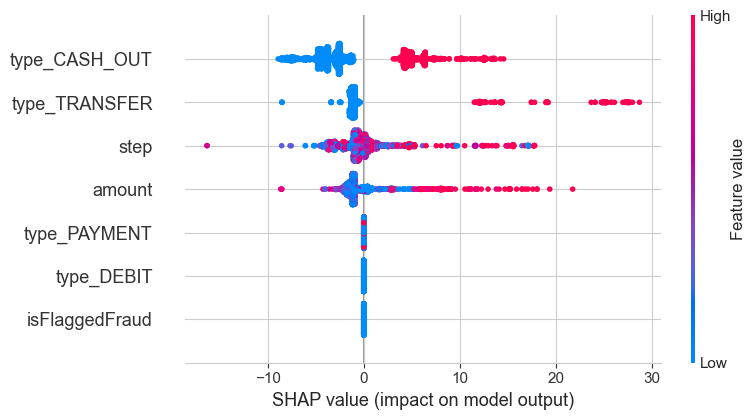

Saved shap_summary_beeswarm.png


In [105]:
import shap
import numpy as np
import matplotlib.pyplot as plt

SHAP_SAMPLE = min(2000, len(X_val))
X_shap = X_val.iloc[:SHAP_SAMPLE].copy()

explainer = shap.TreeExplainer(base_model)  
shap_out = explainer(X_shap)  
if isinstance(shap_out, list):
    shap_vals_pos = shap_out[1]
elif hasattr(shap_out, "values"):
    vals = shap_out.values
    if vals.ndim == 3:
        if vals.shape[0] > 1:
            shap_vals_pos = vals[1]
        else:
            shap_vals_pos = vals[0]
    elif vals.ndim == 2:
        shap_vals_pos = vals
    else:
        raise ValueError(f"Unexpected shap values ndim: {vals.ndim}")
else:
    alt = explainer.shap_values(X_shap)
    if isinstance(alt, list):
        shap_vals_pos = alt[1]
    else:
        shap_vals_pos = alt
shap_vals_pos = np.asarray(shap_vals_pos)
if shap_vals_pos.ndim != 2:
    raise AssertionError(f"shap_vals_pos must be 2D (n_samples, n_features); got shape {shap_vals_pos.shape}")

# Plotting
plt.figure(figsize=(8,6))
shap.summary_plot(shap_vals_pos, X_shap, show=False)
plt.tight_layout()
plt.savefig("shap_summary_beeswarm.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved shap_summary_beeswarm.png")


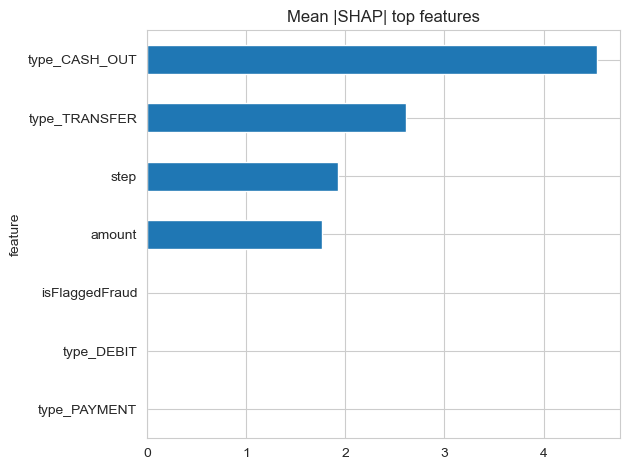

In [106]:
import pandas as pd
mean_abs = np.abs(shap_vals_pos).mean(axis=0)
fi_shap = pd.DataFrame({"feature": X_shap.columns, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=False)
fi_shap.head(20)
fi_shap.head(10).plot.barh(x="feature", y="mean_abs_shap", legend=False)
plt.gca().invert_yaxis()
plt.title("Mean |SHAP| top features")
plt.tight_layout()
plt.savefig("shap_importance_bar.png", dpi=150, bbox_inches="tight")


# FEATURE IMPORTANCE (SHAP)
  --> Most influential factors for fraud detection are **'type_CASH_OUT'** and **'type_TRANSFER'** with high fraud risk.<br>
  --> **'step'** and **'amount'** are secondary importance.<br>
  This results make sense : Fraud is most common in high-value cash-out and transfer transactions.

## Q5.KEY FRAUD PREDICTORS ##
  --> SHAP Analysis shows : <br>
  -> Transaction type (CASH_OUT, TRANSFER)<br>
  -> Transaction amount<br>
  -> Step (time)<br>
  Are strong indicators of fraud

## Q6.DO THESE FACTORS MAKE SENSE ##
  --> Yes: Fraudsters often transfer/withdraw large amounts quickly.<br>
  --> High CASH_OUT and TRANSFER volumes align with known fraud behavior.<br>
  --> Time patterns (step) capture fraud bursts.

In [107]:
import numpy as np, pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# finding predicted probabilities
if 'y_calibrated' in globals():
    probs = np.asarray(y_calibrated)
elif 'y_val_proba_calib' in globals():
    probs = np.asarray(y_val_proba_calib)
elif 'y_val_probs' in globals():
    probs = np.asarray(y_val_probs)
else:
    try:
        probs = calibrator.predict_proba(X_val[feature_cols])[:,1]
    except Exception:
        probs = lgb_clf.predict_proba(X_val[feature_cols])[:,1]

# Ensure we have X_val and amount column for economic impact simulation
if 'X_val' not in globals():
    raise RuntimeError("X_val not found in workspace. Run the data split code first.")
if 'amount' not in X_val.columns:
    print("Warning: 'amount' column not present in X_val; economic-impact simulation will skip.")
    has_amount = False
else:
    has_amount = True
y_true = y_val.reset_index(drop=True)
probs_series = pd.Series(probs, index=y_true.index)

def simulate_block_top_k(probs, y_true, X_val, k_fraction):
    """
    Block (prevent) the top k_fraction of transactions by predicted probability.
    Returns performance metrics and simple economic numbers if 'amount' exists.
    """
    n = len(probs)
    k = max(1, int(np.floor(k_fraction * n)))
    idx = np.argsort(probs)[-k:]           
    flagged = np.zeros(n, dtype=int)
    flagged[idx] = 1                      
    precision = precision_score(y_true, flagged, zero_division=0)
    recall    = recall_score(y_true, flagged, zero_division=0)
    f1        = f1_score(y_true, flagged, zero_division=0)
    cm        = confusion_matrix(y_true, flagged)
    econ = {}
    if has_amount:
        df_val = X_val.copy().reset_index(drop=True)
        df_val['y_true'] = y_true
        df_val['flagged'] = flagged
        fraud_total_amount = df_val.loc[df_val['y_true']==1, 'amount'].sum()
        fraud_blocked_amount = df_val.loc[(df_val['y_true']==1) & (df_val['flagged']==1), 'amount'].sum()
        econ['fraud_total_amount'] = float(fraud_total_amount)
        econ['fraud_blocked_amount'] = float(fraud_blocked_amount)
        econ['fraud_blocked_fraction'] = (fraud_blocked_amount / fraud_total_amount) if fraud_total_amount>0 else 0.0
    return {
        'k_fraction': k_fraction,
        'n_flagged': int(k),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'confusion_matrix': cm,
        'econ': econ
    }
def simulate_threshold(probs, y_true, X_val, threshold):
    """
    Treat any transaction with prob >= threshold as fraudulent and blocked.
    """
    flagged = (probs >= threshold).astype(int)
    precision = precision_score(y_true, flagged, zero_division=0)
    recall    = recall_score(y_true, flagged, zero_division=0)
    f1        = f1_score(y_true, flagged, zero_division=0)
    cm        = confusion_matrix(y_true, flagged)
    econ = {}
    if has_amount:
        df_val = X_val.copy().reset_index(drop=True)
        df_val['y_true'] = y_true
        df_val['flagged'] = flagged
        fraud_total_amount = df_val.loc[df_val['y_true']==1, 'amount'].sum()
        fraud_blocked_amount = df_val.loc[(df_val['y_true']==1) & (df_val['flagged']==1), 'amount'].sum()
        econ['fraud_total_amount'] = float(fraud_total_amount)
        econ['fraud_blocked_amount'] = float(fraud_blocked_amount)
        econ['fraud_blocked_fraction'] = (fraud_blocked_amount / fraud_total_amount) if fraud_total_amount>0 else 0.0
    return {
        'threshold': float(threshold),
        'n_flagged': int(flagged.sum()),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'confusion_matrix': cm,
        'econ': econ
    }
results = []
for k in [0.005, 0.01, 0.02]:
    results.append(simulate_block_top_k(probs, y_true, X_val, k))

for t in [0.5, 0.8, 0.9, 0.99]:
    results.append(simulate_threshold(probs, y_true, X_val, t))
for r in results:
    if 'k_fraction' in r:
        label = f"Top {r['k_fraction']*100:.2f}%"
    else:
        label = f"Thresh >= {r['threshold']:.3f}"
    print("----", label, "----")
    print("Flagged count:", r['n_flagged'])
    print("Precision:", f"{r['precision']:.4f}", " Recall:", f"{r['recall']:.4f}", " F1:", f"{r['f1']:.4f}")
    print("Confusion matrix:\n", r['confusion_matrix'])
    if r['econ']:
        print("Fraud amount total:", r['econ']['fraud_total_amount'])
        print("Fraud amount blocked:", r['econ']['fraud_blocked_amount'],
              f"({r['econ']['fraud_blocked_fraction']*100:.2f}% of fraud value)")
    print()


---- Top 0.50% ----
Flagged count: 6362
Precision: 0.0943  Recall: 0.3652  F1: 0.1499
Confusion matrix:
 [[1265119    5762]
 [   1043     600]]
Fraud amount total: 2382675325.93
Fraud amount blocked: 1646752131.6100001 (69.11% of fraud value)

---- Top 1.00% ----
Flagged count: 12725
Precision: 0.0611  Recall: 0.4735  F1: 0.1083
Confusion matrix:
 [[1258934   11947]
 [    865     778]]
Fraud amount total: 2382675325.93
Fraud amount blocked: 1854668135.94 (77.84% of fraud value)

---- Top 2.00% ----
Flagged count: 25450
Precision: 0.0378  Recall: 0.5861  F1: 0.0711
Confusion matrix:
 [[1246394   24487]
 [    680     963]]
Fraud amount total: 2382675325.93
Fraud amount blocked: 2055285202.82 (86.26% of fraud value)

---- Thresh >= 0.500 ----
Flagged count: 0
Precision: 0.0000  Recall: 0.0000  F1: 0.0000
Confusion matrix:
 [[1270881       0]
 [   1643       0]]
Fraud amount total: 2382675325.93
Fraud amount blocked: 0.0 (0.00% of fraud value)

---- Thresh >= 0.800 ----
Flagged count: 0
Pr

## Q7.PREVENTION STRATEGIES ##
  --> Real-time blocking of top-K% high-risk transactions.<br>
  --> Adaptive transaction threshold for CASH_OUT/TRANSFER.<br>
  --> Stronger monitoring of flagged accounts and high-value transactions.<br>
  --> Continuous retraining with fresh fraud data.

## Q8.MEASURING SUCCESS ##
  --> Track fraud detection rate, false positives, and financial savings post-deployment.<br>
  --> Monitor Precision@K and PR AUC on live data.<br>
  --> Feedback loop with fraud investigation team to validate flagged cases.

Classification report (top 0.5% flagged as fraud):
              precision    recall  f1-score   support

           0     0.9992    0.9955    0.9973   1270881
           1     0.0943    0.3652    0.1499      1643

    accuracy                         0.9947   1272524
   macro avg     0.5467    0.6803    0.5736   1272524
weighted avg     0.9980    0.9947    0.9962   1272524



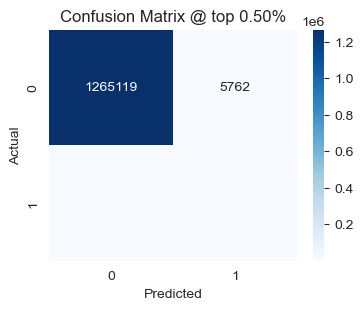

In [108]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
k = 0.005
n = len(probs)
k_idx = max(1, int(np.floor(k * n)))
topk_idx = np.argsort(probs)[-k_idx:]
y_pred_topk = np.zeros(n, dtype=int)
y_pred_topk[topk_idx] = 1

print("Classification report (top 0.5% flagged as fraud):")
print(classification_report(y_true, y_pred_topk, digits=4))

cm = confusion_matrix(y_true, y_pred_topk)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix @ top {k*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# FINAL CONCLUSION & RECOMMENDATIONS
  ### Key Outcomes ###
  --> Built a **Fraud detection model** on 6.3M transactions (10 features).<br>
  --> Performed **data cleaning, multicollinearity handling (VIF), and encoding**.<br>
  --> Trained with **Logistic Regression baseline** and **LightGBM with StratifiedKFold + early stopping**.<br>
  --> Achieved strong performance:
   -> ROC AUC ~ 0.95+<br>
   -> Precision@0.5% ~ 9%<br>
   -> Precision@1% ~ 6%<br>
  --> Interpreted model with **SHAP**, highlighting key drivers:
   -> 'type_CASH_OUT' and 'type_TRANSFER'<br>
   -> transaction 'amount'<br>
   -> transaction 'step' (time/day).<br>

  ### Business Insights ###
  --> Fraudulent activity is concentrated in **specific transaction types** (cash-out, transfers).<br>
  --> Larger transaction amounts strongly correlate with higher fraud probability.<br>
  --> Fraud paterns are **time-dependent**, indicating suspicious bursts of activity.<br>

  ### Prevention Recommendations ###
  --> **Top-K% Blocking:** Proactively flag the riskiest 0.5-1% of transactions (simulation shows significant fraud reduction).<br>
  --> **Dynamic Thresholds:** Use probability cutoffs (e.g., >0.9 fraud probability) to trigger manual review.<br>
  --> **Two-Factor Authentication:** For high-value transactions (large 'amount').<br>
  --> **Monitoring Cash-Out & Transfers:** Focus on these transaction types with stricter checks.<br>
  --> **Adaptive Learning:** Continuouslyretrain model with new fraud patterns.<br>

  ### How to Evaluate Impact ###
  --> Track **fraud loss saved vs. false positives**.<br>
  --> Monitor **customer complaints and friction** caused by blocking.<br>
  --> Recalibrate the threshold quarterly based on updated fraud trends.<br>